#### In this project, I tried to classify galaxies base on their shapes. I used the data in the link, https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge . I used the images in images_training_rev1.zip and probable classifications in training_solutions_rev1.zip to train my model. I have classified images galaxies by selecting class having highest probabilities, creating a dataset folder 9galaxy. I sampled only the good quality images from the given dataset. In addition, I have removed the blurry images(size <15kb) and other bad quality images from the original data. I have also edited some images manually to remove unnecessary noise. To increase the accuracy of training dataset I have only taken four classes which had less classification error.

### Code used to classify the data based on highest probability of the class on csv file:
### Let's classify the images in images_training_rev1 according to the classification in csv files.

import shutil

csv_file = "path to the csv file" 
images_folder = "path to the images_training_rev1 directory"     
output_folder ="Directory classified_images"      


df = pd.read_csv(csv_file)

print(df['GalaxyID'].dtype)  
print(df['GalaxyID'].isnull().sum())  
df['GalaxyID'] = df['GalaxyID'].astype(str)


classes = df.columns[1:]  # Skip the image_id column
for cls in classes:
    os.makedirs(os.path.join(output_folder, cls), exist_ok=True)


for _, row in df.iterrows():
    image_id = row['GalaxyID'] + '.jpg' 
    
    
    for cls in classes:
        if row[cls] == row[1::].max():  # Assuming the class with maximum value indicates the image belongs to the class
            src = os.path.join(images_folder, image_id)
            dst = os.path.join(output_folder, cls, image_id)
            if os.path.exists(src):  # Check if the image file exists
                shutil.copy(src, dst)  # Copy the image to the class folder
            else:
                pass





### Code used to divide the dataset into training dataset and validation dataset



dataset_dir = "path to the classified_images"  
train_dir = "Directory to save training data set"  
val_dir = "Directory to save validation data set"      


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):  
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        
        all_files = os.listdir(class_path)
        
        
        np.random.shuffle(all_files)
        
        
        split_index = int(0.8 * len(all_files))
        train_files = all_files[:split_index]
        val_files = all_files[split_index:]

        
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))

        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))




In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.applications import InceptionV3

# Loading InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = "/kaggle/input/9galaxy/training_dataset/training_dataset"
validation_data_dir = "/kaggle/input/9galaxy/validation_dataset/validation_dataset"

train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.5  # Use 50% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Resize images to match model input size
    batch_size=12,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299, 299),
    batch_size=12,
    class_mode='categorical',
    subset='validation'
)


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest',
      )


Found 1406 images belonging to 4 classes.
Found 366 images belonging to 4 classes.


In [5]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pooling layer
x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
predictions = layers.Dense(4, activation='softmax')(x)  # 3 classes for galaxies

# Create the final model
model = models.Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/kaggle/working/my_galaxy_model.keras",
                              monitor="val_loss",
                              mode="min",
                              save_best_only = True,
                              verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 5,
                             verbose = 1,
                             restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]


model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=45)


Epoch 1/45


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728828492.178690     995 service.cc:145] XLA service 0x7e3d44002dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728828492.178748     995 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728828492.178753     995 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.3241 - loss: 2.0446 

I0000 00:00:1728828501.241996     995 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - accuracy: 0.6712 - loss: 0.9919 - val_accuracy: 0.7705 - val_loss: 0.6516
Epoch 2/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7934 - loss: 0.5359 - val_accuracy: 0.8497 - val_loss: 0.4450
Epoch 3/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8098 - loss: 0.4459 - val_accuracy: 0.8361 - val_loss: 0.4570
Epoch 4/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8330 - loss: 0.4149 - val_accuracy: 0.8169 - val_loss: 0.5058
Epoch 5/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8220 - loss: 0.4018 - val_accuracy: 0.8443 - val_loss: 0.4349
Epoch 6/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8204 - loss: 0.4073 - val_accuracy: 0.8415 - val_loss: 0.4794
Epoch 7/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8541 - loss: 0.3849 - val_accuracy: 0.8470 - val_loss: 0.4627
Epoch 8/45
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8738 - loss: 0.2909 - val_accuracy: 0.8

In [7]:
# CLASSIFICATION REPORT AND THE CONFUSION MATRIX FOR THE inceptionv3
# Displaying our Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
class_labels = {0: 'Galaxy with Disk', 1: 'Irregular Galaxy', 2:'Smooth Elliptical Galaxy', 3: 'Spiral Galaxy with Bulge'}



#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, validation_data_dir) # put classifier not model
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))



31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step
Confusion Matrix
[[126  17  35  40]
 [ 23   2   1   5]
 [ 22   9   3   4]
 [ 58   5   6  10]]
Classification Report
                          precision    recall  f1-score   support

        Galaxy with Disk       0.55      0.58      0.56       218
        Irregular Galaxy       0.06      0.06      0.06        31
Smooth Elliptical Galaxy       0.07      0.08      0.07        38
Spiral Galaxy with Bulge       0.17      0.13      0.14        79

                accuracy                           0.39       366
               macro avg       0.21      0.21      0.21       366
            weighted avg       0.38      0.39      0.38       366



In [8]:
model.save('/kaggle/working/my_galaxy_model1.keras')


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step


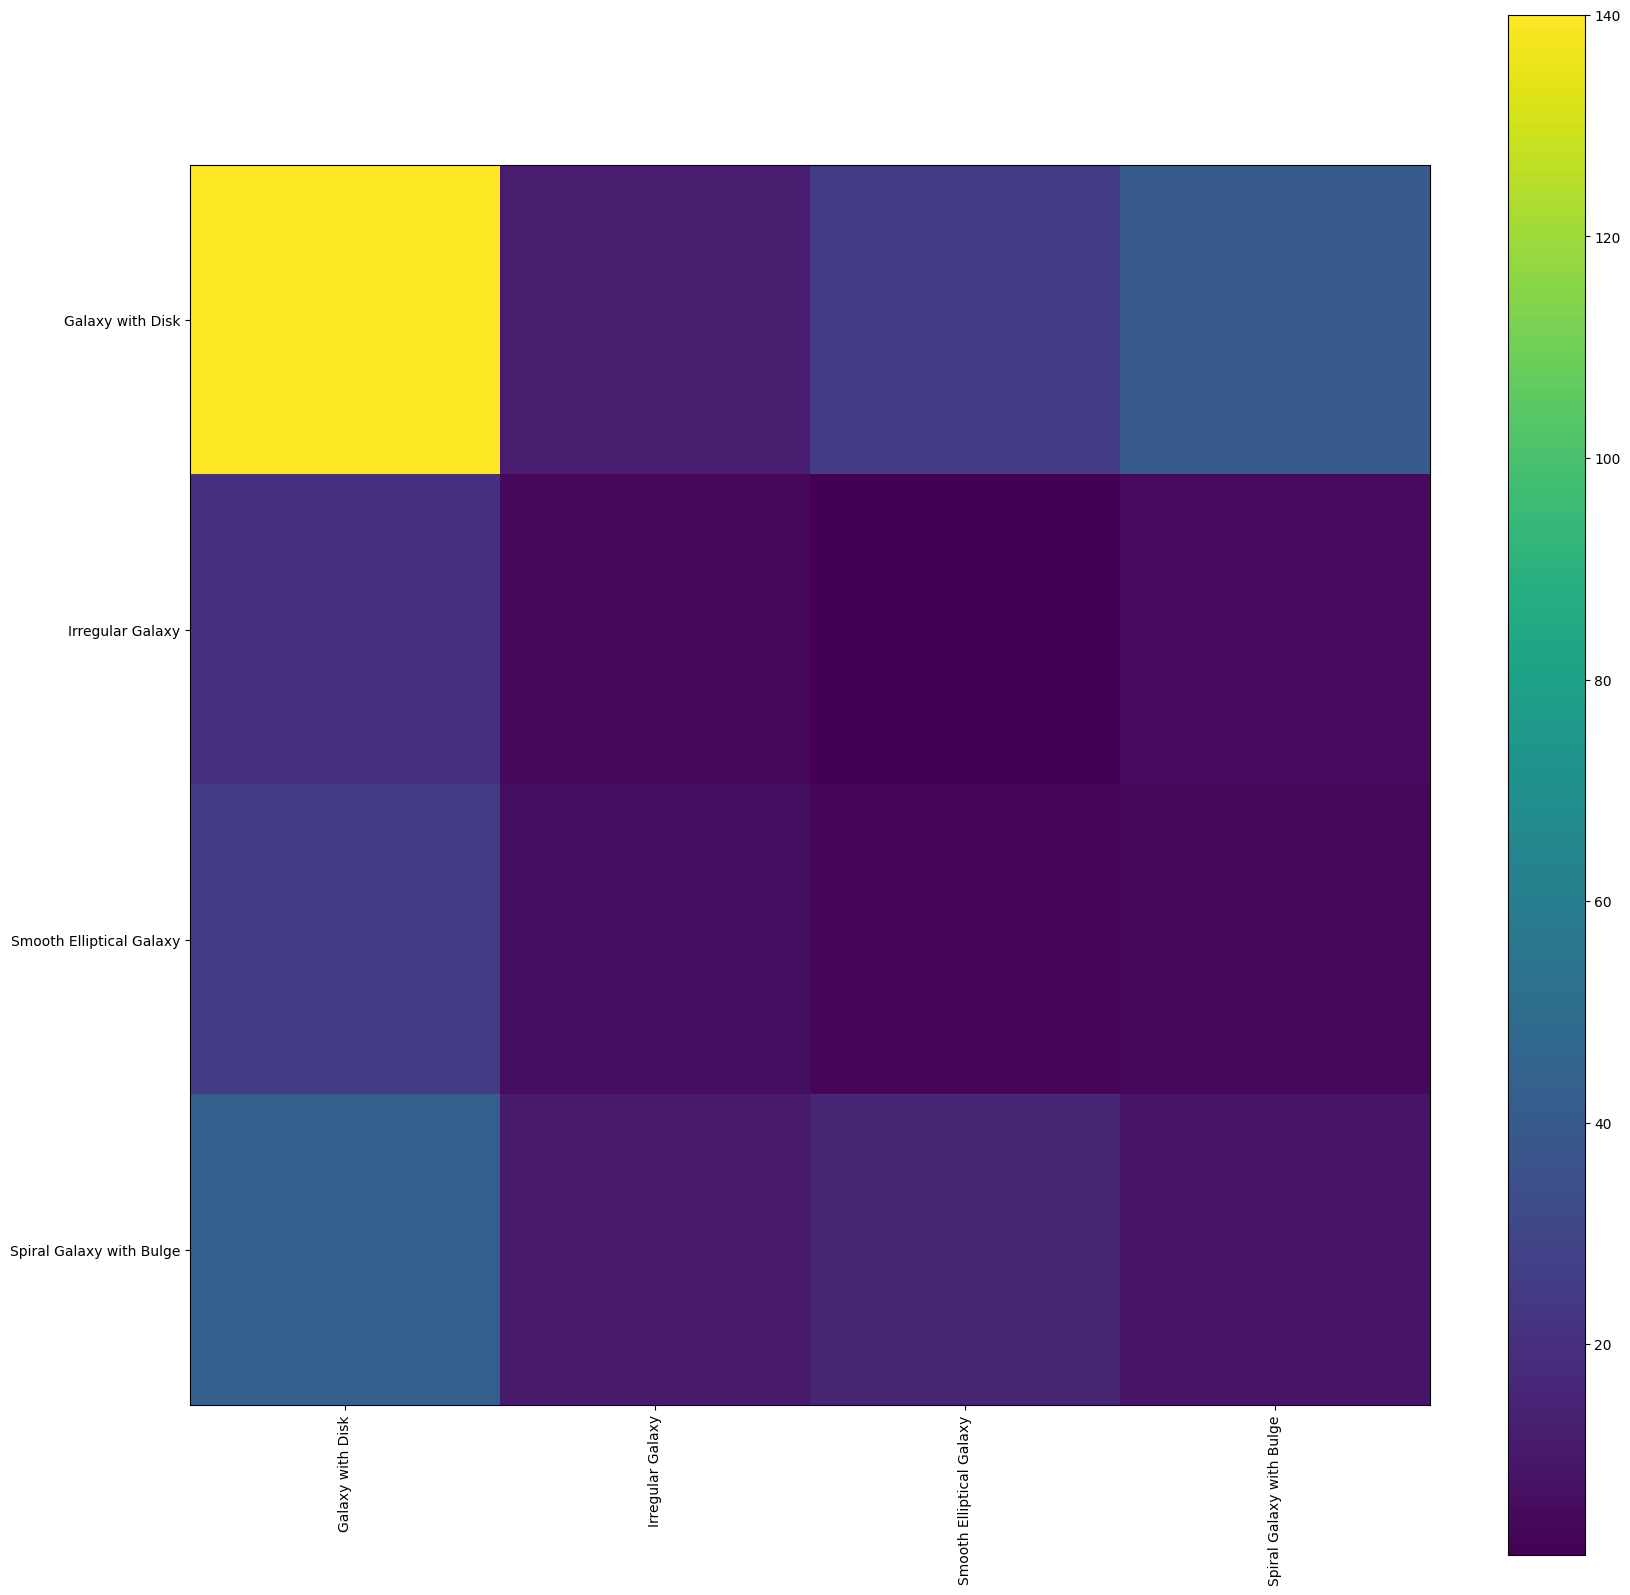

In [9]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 224,224,3
model = load_model("/kaggle/working/my_galaxy_model1.keras")

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 475
nb_validation_samples = 139

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

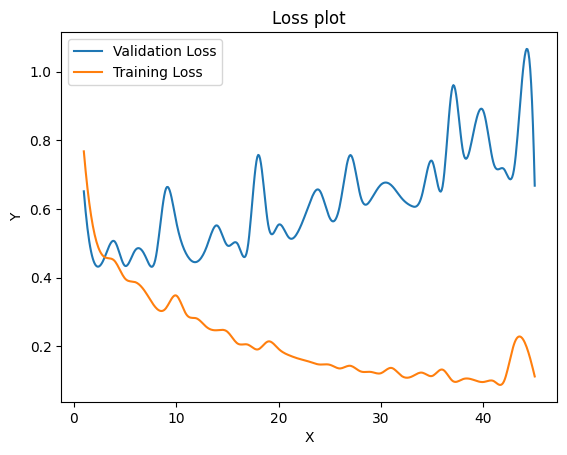

In [11]:

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
n = len(loss_values)
epochs = range(1, len(loss_values) + 1)
y=history_dict['loss']
y1=history_dict['val_loss']

model = make_interp_spline(epochs, y)
model1 = make_interp_spline(epochs, y1)
xs=np.linspace(1,n,500)
ys=model(xs)
ys1 = model1(xs)

plt.xlabel('Epochs')
plt.plot(xs, ys1, label='Validation Loss')
plt.plot(xs, ys,label='Training Loss')
plt.title("Loss plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

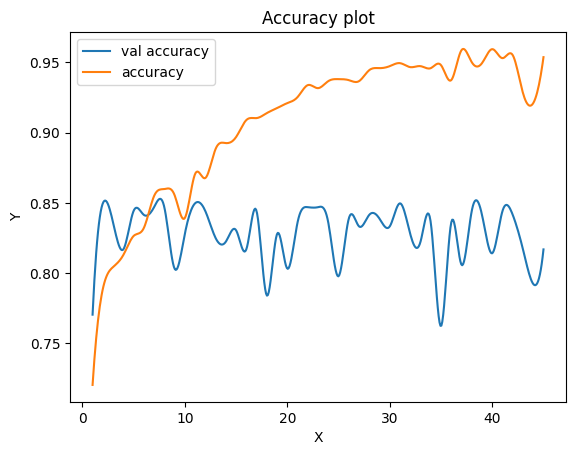

In [12]:


history_dict = history.history
loss_values = history_dict['loss']
n = len(loss_values)
epochs = range(1, len(loss_values) + 1)
y=history_dict['accuracy']
y1=history_dict['val_accuracy']

model=make_interp_spline(epochs, y)
model1=make_interp_spline(epochs, y1)
xs=np.linspace(1,n,500)
ys=model(xs)
ys1 = model1(xs)
plt.xlabel('Epochs')
plt.plot(xs, ys1, label='val accuracy')
plt.plot(xs, ys,label='accuracy')
plt.title("Accuracy plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## References:

1. AstroDave, AstroTom, Christopher Read @ Winton, joycenv, Kyle Willett. (2013). Galaxy Zoo - The Galaxy Challenge. Kaggle. https://kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge

2. Aayush Adhikari. (2024). AI at 5 pm [Lecture notes]. Artificial Intellegence Class, Broadway Infosys. https://broadwayinfosys.com/

3. OpenAI. (2023). ChatGPT [AI language model]. https://openai.com/chatgpt